In [1]:
#Following libraries were imported.
import numpy as np
import pandas as pd
import seaborn as sns
import math

from sklearn.metrics import confusion_matrix

from PIL import Image as im
from PIL import Image
import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader , TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from scipy.fftpack import fft2
from scipy.fftpack import fftshift

from scipy.fftpack import fft2
from scipy.fftpack import fftshift

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Following code will generate the image of the wedge with different angle.
def Object_wedge_Angle_fft(Alpha,Nx=500,Ny=500):
  Wedge_grating = np.ones([Nx,Ny])
  for i in range(Nx):
    for j in range(Ny):
      x0=Nx/2
      y0=Ny/2
      x=i-x0
      y=j-y0
      r=np.sqrt(x**2+y**2)
      if x<0:
        w_angle=-1*math.degrees(math.acos(y/r))
      else:
        w_angle=math.degrees(math.acos(y/r))

      if r<(Nx/4) :
          Wedge_grating[i,j]=0
      else:
        Wedge_grating[i,j]=1
      
      if w_angle<= Alpha and w_angle>=0:
        Wedge_grating[i,j]=1

  for i1 in range(Nx):
    for j1 in range(Ny):
      x0=Nx/2
      y0=Ny/2
      x=i1-x0
      y=j1-y0
      r=np.sqrt(x**2+y**2)
      if r>(Nx//4-4) :
          Wedge_grating[i1,j1]=0    

  Wedge_grating=cv2.flip(Wedge_grating,0)
  
  return Wedge_grating


# Wedge

In [362]:
#Dimension and length of screen and grating.

#Grating size
Nx=1500
Ny=1500

#Grating dimension in mm
Lx = 10.0
Ly = 10.0

dx = Lx/Nx
dy = Ly/Ny

x = dx*(np.arange(Nx)-Nx//2)
y = dy*(np.arange(Ny)-Ny//2)
xx, yy = np.meshgrid(x, y)

In [397]:
# distance from slit to the screen (mm)
z = 220

# wavelength (mm)
wavelength = 532*1e-6
k = 2*np.pi/wavelength

#This code is used to get the diifraction pattern from fft2 and fftshift

fft_c = fft2(Object_wedge_Angle_fft(Alpha=26,Nx=1500,Ny=1500) * np.exp(1j * k/(2*z) *(xx**2 + yy**2)))
c = fftshift(fft_c)
abs_c = np.absolute(c)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


(-0.5, 1499.5, 1499.5, -0.5)

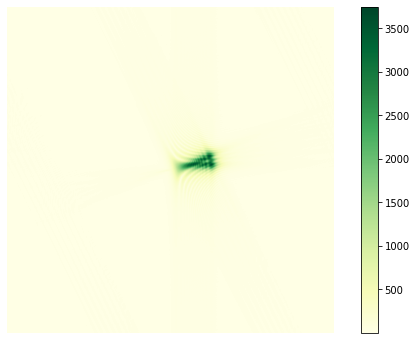

In [398]:
#Diffraction Pattern
plt.figure(figsize=(10,6))
plt.imshow(abs_c ,cmap ='YlGn')
plt.colorbar()
plt. axis('off')

#Dataset Generation and Data Augmentation

In [360]:
Wedge_Angle=np.array([2*np.pi/i for i in range(2,16)])

In [363]:
#This code is used to generate the final image for training for the Neural Net.
Diffraction_pattern_dict={}
One_hot_representation=[]
for i in range(len(Wedge_Angle)):
  one_hot_vector=list(np.zeros(len(Wedge_Angle)))
  one_hot_vector[i]=1
  One_hot_representation.append(one_hot_vector)
  wi=Object_wedge_Angle_fft(Alpha=np.degrees(Wedge_Angle[i]),Nx=1500,Ny=1500)
  fft_c = fft2( wi* np.exp(1j * k/(2*z) *(xx**2 + yy**2)))
  c = fftshift(fft_c)
  diffraction_pattern=np.absolute(c)
  norm_img = np.zeros(diffraction_pattern.shape)
  final_img =cv2.normalize(diffraction_pattern,norm_img, 0,255,cv2.NORM_MINMAX)
  final_img= final_img.astype(np.uint8)
  
  #Image size resize to (60,60)
  resized = cv2.resize(final_img, (60,60), interpolation=cv2.INTER_AREA)
  Diffraction_pattern_dict.update({str(i):resized})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


## Data Augmentation

### Training Dataset

In [ ]:
#Below code is used to generate the dataset for training the neural network.
Train_tensor=np.zeros([(len(Wedge_Angle))*401,1,60,60])
Augmentation_value1=np.linspace(1,3,100)
Augmentation_value2=np.linspace(0.1,0.5,100)
count=0
for i in range(len(Wedge_Angle)):
  Train_tensor[count]=Diffraction_pattern_dict[str(i)]
  count+=1

##DATA SET generation of brightness.
for i in range(len(Wedge_Angle)):
  data = Diffraction_pattern_dict[str(i)]
  PIL_image = Image.fromarray(data)
  for j in range(100):

    loader_transform = transforms.ColorJitter(brightness=Augmentation_value1[j])
    imageb=loader_transform(PIL_image)
    imageb_array=np.asarray(imageb)
    Train_tensor[count]=imageb_array

    one_hot_vector=list(np.zeros(len(Wedge_Angle)))
    one_hot_vector[i]=1
    One_hot_representation.append(one_hot_vector)

    count+=1

##DATA SET generation of contrast.
for i in range(len(Wedge_Angle)):
  data = Diffraction_pattern_dict[str(i)]
  PIL_image = Image.fromarray(data)
  for j in range(100):

    loader_transform = transforms.ColorJitter(contrast=Augmentation_value1[j])
    imageb=loader_transform(PIL_image)
    imageb_array=np.asarray(imageb)
    Train_tensor[count]=imageb_array

    one_hot_vector=list(np.zeros(len(Wedge_Angle)))
    one_hot_vector[i]=1
    One_hot_representation.append(one_hot_vector)

    count+=1

##DATA SET generation of saturation.
for i in range(len(Wedge_Angle)):
  data = Diffraction_pattern_dict[str(i)]
  PIL_image = Image.fromarray(data)
  for j in range(100):

    loader_transform = transforms.ColorJitter(saturation=Augmentation_value1[j])
    imageb=loader_transform(PIL_image)
    imageb_array=np.asarray(imageb)
    Train_tensor[count]=imageb_array

    one_hot_vector=list(np.zeros(len(Wedge_Angle)))
    one_hot_vector[i]=1
    One_hot_representation.append(one_hot_vector)

    count+=1

##DATA SET generation of hue.
for i in range(len(Wedge_Angle)):
  data = Diffraction_pattern_dict[str(i)]
  PIL_image = Image.fromarray(data)
  for j in range(100):

    loader_transform = transforms.ColorJitter(hue=Augmentation_value2[j])
    imageb=loader_transform(PIL_image)
    imageb_array=np.asarray(imageb)
    Train_tensor[count]=imageb_array

    one_hot_vector=list(np.zeros(len(Wedge_Angle)))
    one_hot_vector[i]=1
    One_hot_representation.append(one_hot_vector)

    count+=1

One_hot_representation=np.array(One_hot_representation)

train_dataset={'image':Train_tensor,'label':One_hot_representation}

#validation dataset

In [ ]:
#This code is used to generate the final image for validation the neral network in dictionary.
Diffraction_pattern_dict={}
One_hot_representation=[]
for i in range(len(Wedge_Angle)):
  one_hot_vector=list(np.zeros(len(Wedge_Angle)))
  one_hot_vector[i]=1
  One_hot_representation.append(one_hot_vector)
  fft_c = fft2(Object_wedge_Angle_fft(Alpha=np.degrees(Wedge_Angle[i]),Nx=1500,Ny=1500) * np.exp(1j * k/(2*z) *(xx**2 + yy**2)))
  c = fftshift(fft_c)
  diffraction_pattern=np.absolute(c)
  norm_img = np.zeros(diffraction_pattern.shape)
  final_img = cv2.normalize(diffraction_pattern,  norm_img, 0, 255, cv2.NORM_MINMAX)
  final_img= final_img.astype(np.uint8)
  
  #Image size resize to (60,60)
  resized = cv2.resize(final_img, (60,60), interpolation=cv2.INTER_AREA)
  Diffraction_pattern_dict.update({str(i):resized})

#Below code is used to generate the dataset for validation the neural network.
val_tensor=np.zeros([(len(Wedge_Angle))*161,1,60,60])
Augmentation_value1=np.linspace(1,3,40)
Augmentation_value2=np.linspace(0.1,0.5,40)
count=0
for i in range(len(Wedge_Angle)):
  val_tensor[count]=Diffraction_pattern_dict[str(i)]
  count+=1

##DATA SET generation of brightness.
for i in range(len(Wedge_Angle)):
  data = Diffraction_pattern_dict[str(i)]
  PIL_image = Image.fromarray(data)
  for j in range(40):

    loader_transform = transforms.ColorJitter(brightness=Augmentation_value1[j])
    imageb=loader_transform(PIL_image)
    imageb_array=np.asarray(imageb)
    val_tensor[count]=imageb_array

    one_hot_vector=list(np.zeros(len(Wedge_Angle)))
    one_hot_vector[i]=1
    One_hot_representation.append(one_hot_vector)

    count+=1

##DATA SET generation of contrast.
for i in range(len(Wedge_Angle)):
  data = Diffraction_pattern_dict[str(i)]
  PIL_image = Image.fromarray(data)
  for j in range(40):

    loader_transform = transforms.ColorJitter(contrast=Augmentation_value1[j])
    imageb=loader_transform(PIL_image)
    imageb_array=np.asarray(imageb)
    val_tensor[count]=imageb_array

    one_hot_vector=list(np.zeros(len(Wedge_Angle)))
    one_hot_vector[i]=1
    One_hot_representation.append(one_hot_vector)

    count+=1

##DATA SET generation of saturation.
for i in range(len(Wedge_Angle)):
  data = Diffraction_pattern_dict[str(i)]
  PIL_image = Image.fromarray(data)
  for j in range(40):

    loader_transform = transforms.ColorJitter(saturation=Augmentation_value1[j])
    imageb=loader_transform(PIL_image)
    imageb_array=np.asarray(imageb)
    val_tensor[count]=imageb_array

    one_hot_vector=list(np.zeros(len(Wedge_Angle)))
    one_hot_vector[i]=1
    One_hot_representation.append(one_hot_vector)

    count+=1

##DATA SET generation of hue.
for i in range(len(Wedge_Angle)):
  data = Diffraction_pattern_dict[str(i)]
  PIL_image = Image.fromarray(data)
  for j in range(40):

    loader_transform = transforms.ColorJitter(hue=Augmentation_value2[j])
    imageb=loader_transform(PIL_image)
    imageb_array=np.asarray(imageb)
    val_tensor[count]=imageb_array

    one_hot_vector=list(np.zeros(len(Wedge_Angle)))
    one_hot_vector[i]=1
    One_hot_representation.append(one_hot_vector)

    count+=1

One_hot_representation=np.array(One_hot_representation)

val_dataset={'image':val_tensor,'label':One_hot_representation}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


#Testing_dataset

In [ ]:
#This code is used to generate the final image for testing the neral network in dictionary.
Diffraction_pattern_dict={}
One_hot_representation=[]
for i in range(len(Wedge_Angle)):
  one_hot_vector=list(np.zeros(len(Wedge_Angle)))
  one_hot_vector[i]=1
  One_hot_representation.append(one_hot_vector)
  fft_c = fft2(Object_wedge_Angle_fft(Alpha=np.degrees(Wedge_Angle[i]),Nx=1500,Ny=1500) * np.exp(1j * k/(2*z) *(xx**2 + yy**2)))
  c = fftshift(fft_c)
  diffraction_pattern=np.absolute(c)  
  norm_img = np.zeros(diffraction_pattern.shape)
  final_img = cv2.normalize(diffraction_pattern,  norm_img, 0, 255, cv2.NORM_MINMAX)
  final_img= final_img.astype(np.uint8)

  resized = cv2.resize(final_img, (60,60), interpolation=cv2.INTER_AREA)
  Diffraction_pattern_dict.update({str(i):resized})

test_tensor=np.zeros([(len(Wedge_Angle))*161,1,60,60])
Augmentation_value1=np.linspace(1,3,40)
Augmentation_value2=np.linspace(0.1,0.5,40)
count=0
for i in range(len(Wedge_Angle)):
  test_tensor[count]=Diffraction_pattern_dict[str(i)]
  count+=1

##DATA SET generation of brightness.
for i in range(len(Wedge_Angle)):
  data = Diffraction_pattern_dict[str(i)]
  PIL_image = Image.fromarray(data)
  for j in range(40):

    loader_transform = transforms.ColorJitter(brightness=Augmentation_value1[j])
    imageb=loader_transform(PIL_image)
    imageb_array=np.asarray(imageb)
    test_tensor[count]=imageb_array

    one_hot_vector=list(np.zeros(len(Wedge_Angle)))
    one_hot_vector[i]=1
    One_hot_representation.append(one_hot_vector)

    count+=1

##DATA SET generation of contrast.
for i in range(len(Wedge_Angle)):
  data = Diffraction_pattern_dict[str(i)]
  PIL_image = Image.fromarray(data)
  for j in range(40):

    loader_transform = transforms.ColorJitter(contrast=Augmentation_value1[j])
    imageb=loader_transform(PIL_image)
    imageb_array=np.asarray(imageb)
    test_tensor[count]=imageb_array

    one_hot_vector=list(np.zeros(len(Wedge_Angle)))
    one_hot_vector[i]=1
    One_hot_representation.append(one_hot_vector)

    count+=1

##DATA SET generation of saturation.
for i in range(len(Wedge_Angle)):
  data = Diffraction_pattern_dict[str(i)]
  PIL_image = Image.fromarray(data)
  for j in range(40):

    loader_transform = transforms.ColorJitter(saturation=Augmentation_value1[j])
    imageb=loader_transform(PIL_image)
    imageb_array=np.asarray(imageb)
    test_tensor[count]=imageb_array

    one_hot_vector=list(np.zeros(len(Wedge_Angle)))
    one_hot_vector[i]=1
    One_hot_representation.append(one_hot_vector)

    count+=1

##DATA SET generation of hue.
for i in range(len(Wedge_Angle)):
  data = Diffraction_pattern_dict[str(i)]
  PIL_image = Image.fromarray(data)
  for j in range(40):

    loader_transform = transforms.ColorJitter(hue=Augmentation_value2[j])
    imageb=loader_transform(PIL_image)
    imageb_array=np.asarray(imageb)
    test_tensor[count]=imageb_array

    one_hot_vector=list(np.zeros(len(Wedge_Angle)))
    one_hot_vector[i]=1
    One_hot_representation.append(one_hot_vector)

    count+=1

One_hot_representation=np.array(One_hot_representation)

test_dataset={'image':test_tensor,'label':One_hot_representation}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


# Data Loader

In [ ]:
train_d=TensorDataset(torch.tensor(train_dataset['image'],dtype=torch.float), torch.tensor(train_dataset['label'],dtype=torch.float))
train_loader = DataLoader(train_d, batch_size=32, shuffle=True)

val_d=TensorDataset(torch.tensor(val_dataset['image'],dtype=torch.float), torch.tensor(val_dataset['label'],dtype=torch.float))
val_loader = DataLoader(val_d, batch_size=32, shuffle=True)

test_d=TensorDataset(torch.tensor(test_dataset['image'],dtype=torch.float), torch.tensor(test_dataset['label'],dtype=torch.float))
test_loader = DataLoader(test_d, batch_size=32, shuffle=False)

#CNN Code

In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels= 3, kernel_size= 3, stride=1, padding=1 )
        self.conv2 = nn.Conv2d(in_channels=3, out_channels= 3, kernel_size= 3, stride=1, padding=1 )
        self.conv3 = nn.Conv2d(in_channels=3, out_channels= 3, kernel_size= 3, stride=1, padding=1 )
        self.max1=nn.MaxPool2d(kernel_size=2, stride=1)
        self.max2=nn.MaxPool2d(kernel_size=2, stride=1)
        self.max3=nn.MaxPool2d(kernel_size=2, stride=1)
        self.fc1 = nn.Linear(3*57*57, 360)
        self.fc2 = nn.Linear(360, 120)
        self.fc3 = nn.Linear(120,14)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.max1(X)
        X = F.relu(self.conv2(X))
        X = self.max2(X)
        X = F.relu(self.conv3(X))
        X = self.max3(X)

        X = X.view(-1, 3*57*57)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

CNN=ConvolutionalNetwork()
CNN=CNN.cuda()

In [ ]:
CNN

ConvolutionalNetwork(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (max2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (max3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9747, out_features=360, bias=True)
  (fc2): Linear(in_features=360, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=14, bias=True)
)

In [ ]:
#parameters are
params = np.sum([p.numel() for p in CNN.parameters()])
print(params)

3554492


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

epochs = 20
ep=0
train_losses = []
val_losses = []
train_correct = []
val_correct = []
print('Training of Neural Network started.... \n')

for i in range(epochs):
    ep+=1
    trn_corr = 0
    val_corr = 0
    
    Train_total=0
    Train_loss=0
    val_total=0
    val_loss=0

    for b, (X_train, y_train) in enumerate(train_loader):
      Train_total+=y_train.shape[0]
      X_train= X_train.cuda()
      y_train=y_train.cuda()

      y_pred=CNN(X_train)
      loss = criterion(y_pred, y_train)
      Train_loss+=loss.item()

      prediction=torch.max(y_pred.data,1)[1]
      original=torch.max(y_train.data,1)[1]
      batch_corr = (prediction==original).sum()
      trn_corr += batch_corr.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print("Training data \n  epochs = {} : Loss = {} : accuracy : {} \n ".format(ep,Train_loss,trn_corr*100/Train_total))
    train_losses.append(Train_loss)
    train_correct.append(trn_corr*100/Train_total)

    with torch.no_grad():
      for b, (X_val, y_val) in enumerate(val_loader):
        val_total+=y_val.shape[0]
        X_val=X_val.cuda()
        y_val=y_val.cuda()

        y_pred_val = CNN(X_val)
        loss = criterion(y_pred_val, y_val)
        val_loss+=loss.item()

        prediction=torch.max(y_pred_val.data,1)[1]
        original=torch.max(y_val.data,1)[1]
        val_corr += ((prediction==original).sum()).item()
      
      print("validation data \n epochs = {} : Loss = {} : accuracy : {} \n ".format(ep,val_loss,val_corr*100/val_total))
      val_losses.append(val_loss)
      val_correct.append(val_corr*100/val_total)

print('Finished Training......')


Training of Neural Network started.... 

Training data 
  epochs = 1 : Loss = 146.11495085060596 : accuracy : 72.78232988956181 
 
validation data 
 epochs = 1 : Loss = 18.022940136492252 : accuracy : 92.99023957409051 
 
Training data 
  epochs = 2 : Loss = 21.14508945820853 : accuracy : 96.86498040612754 
 
validation data 
 epochs = 2 : Loss = 3.7357680366840214 : accuracy : 98.75776397515529 
 
Training data 
  epochs = 3 : Loss = 16.07263816986233 : accuracy : 98.11186319914499 
 
validation data 
 epochs = 3 : Loss = 7.3340349439531565 : accuracy : 96.6282165039929 
 
Training data 
  epochs = 4 : Loss = 7.153688495774986 : accuracy : 99.07374421090132 
 
validation data 
 epochs = 4 : Loss = 2.1253171845237375 : accuracy : 99.24578527063 
 
Training data 
  epochs = 5 : Loss = 9.80028948421159 : accuracy : 98.34342714641967 
 
validation data 
 epochs = 5 : Loss = 1.62643988574564 : accuracy : 99.42324755989353 
 
Training data 
  epochs = 6 : Loss = 20.01720568260953 : accuracy

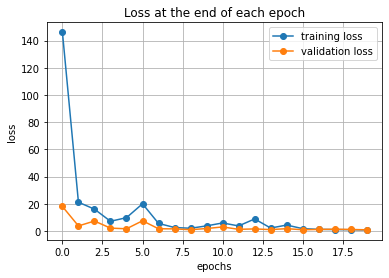

In [ ]:
plt.plot(train_losses,marker="o", label='training loss')
plt.plot(val_losses,marker="o", label='validation loss')
plt.title('Loss at the end of each epoch')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

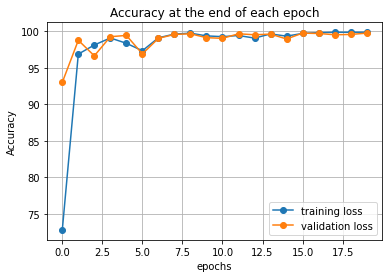

In [ ]:
plt.plot(train_correct,marker="o", label='training loss')
plt.plot(val_correct,marker="o", label='validation loss')
plt.title('Accuracy at the end of each epoch')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

# Accuracy on Testing dataset

In [ ]:
#This code is used to find accuracy on test data.
test_corr=0
test_total=0

y_test_cnn=[]
y_pred_cnn=[]
with torch.no_grad():
  for b, (X_test, y_test) in enumerate(test_loader):
    test_total+=y_test.shape[0]
    X_test=X_test.cuda()
    y_test=y_test.cuda()

    y_pred_test = CNN(X_test)
    
    for i in list(torch.Tensor.cpu(torch.max(y_pred_test.data,1)[1]).detach().numpy()):
      y_pred_cnn.append(i)
    
    for j in list(torch.Tensor.cpu(torch.max(y_test.data,1)[1]).detach().numpy()):
      y_test_cnn.append(j)

    prediction=torch.max(y_pred_test.data,1)[1]
    original=torch.max(y_test.data,1)[1]
    test_corr += ((prediction==original).sum()).item()

  y_test_cnn=np.array(y_test_cnn)
  y_pred_cnn=np.array(y_pred_cnn)
  print("Testing Dataset Accuarcy \n accuracy : {} \n ".format(test_corr*100/test_total))

Testing Dataset Accuarcy 
 accuracy : 99.7338065661047 
 


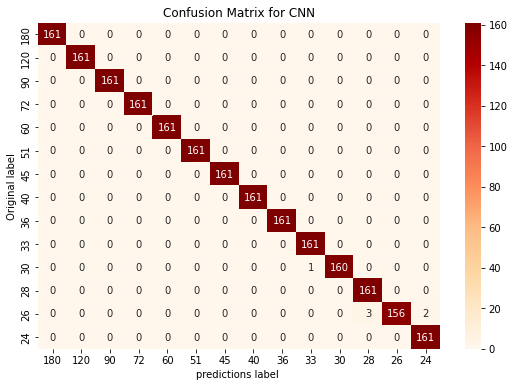

In [ ]:
#Calculating confusion matrix
conf_cnn=confusion_matrix(y_test_cnn, y_pred_cnn)

Class_name=[]
Class_names1=np.degrees(Wedge_Angle)
for i in Class_names1:
  Class_name.append(str(round(i)))

df_cnn = pd.DataFrame(conf_cnn, Class_name, Class_name)
plt.figure(figsize = (9,6))
sns.heatmap(df_cnn, annot=True, fmt="d", cmap='OrRd')
plt.title('Confusion Matrix for CNN')
plt.xlabel("predictions label ")
plt.ylabel(" Original label ")
plt.show()

#KNN on dataset

In [ ]:
# Import necessary modules
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
#flattening of image on train dataset.
X_train=np.zeros((train_dataset['image'].shape[0],3600))
for i in range(train_dataset['image'].shape[0]):
  X_train[i]=train_dataset['image'][i][0].flatten()

Y_train1=torch.from_numpy(train_dataset['label'])
Y_train=torch.max(Y_train1.data,1)[1].detach().numpy()

In [ ]:
#flattening of image on test dataset.
X_test=np.zeros((test_dataset['image'].shape[0],3600))
for i in range(test_dataset['image'].shape[0]):
  X_test[i]=test_dataset['image'][i][0].flatten()

Y_test1=torch.from_numpy(test_dataset['label'])
Y_test=torch.max(Y_test1.data,1)[1].detach().numpy()

No handles with labels found to put in legend.


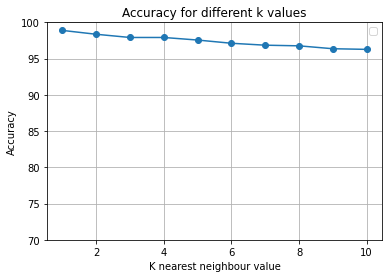

In [ ]:
#checking accuracy for different k_values.
K_values=[1,2,3,4,5,6,7,8,9,10]
Accuracy=[]
for k in K_values:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, Y_train)
  # Calculate the accuracy of the model
  Accuracy.append(knn.score(X_test, Y_test)*100)

plt.plot(K_values,Accuracy,marker="o",color='maroon')
plt.title('Accuracy for different k values')
plt.xlabel('K nearest neighbour value')
plt.ylim(90,100)
plt.ylabel('Accuracy')
plt.grid()
plt.show()


In [ ]:
#Selecting KNN as 1.
knn = KNeighborsClassifier(n_neighbors=1)

In [ ]:
#Fitting the dataset.
knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
# Calculate the accuracy of the model
print(knn.score(X_test, Y_test)*100)

98.89086069210293


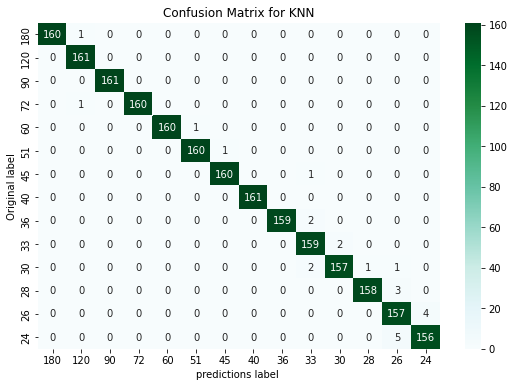

In [ ]:
#Calculating confusion matrix
y_pred = knn.predict(X_test)
conf_knn=confusion_matrix(Y_test, y_pred)

Class_name=[]
Class_names1=np.degrees(Wedge_Angle)
for i in Class_names1:
  Class_name.append(str(round(i)))

df_knn = pd.DataFrame(conf_knn, Class_name, Class_name)
plt.figure(figsize = (9,6))
sns.heatmap(df_knn, annot=True, fmt="d", cmap='BuGn')
plt.title('Confusion Matrix for KNN')
plt.xlabel("predictions label ")
plt.ylabel(" Original label ")
plt.show()
